## Part 1

### Loading the datasets
#### 1. Confirmed URL : https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
#### 2. Deaths URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
#### 3. Recovered URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

#### Starting date on all three datasets is 22/01/2020

Steps (Without BeautifulSoup):-
1. Import the CSV 
2. Check if the last column title matches with the last date row in the cleaned dataset.
3. If it matches, don't add it to the dataset. 
4. If it does not match, go back iteratively until it matches and save all of the data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup

Using TensorFlow backend.


In [2]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

### Function to get the number of confirmed cases as a Dataframe

In [3]:
def get_confirmed():
    con_casesnew = pd.read_csv(confirmed_url)
    con_casesnew = con_casesnew.sum(axis=0)
    con_casesnew.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    con_casesnew = pd.DataFrame(con_casesnew)
    con_casesnew.rename(columns={0: "Infected"}, inplace=True)
    return con_casesnew

### Function to get the number of deaths as a Dataframe

In [4]:
def get_deaths():
    deaths_new = pd.read_csv(deaths_url)
    deaths_new = deaths_new.sum(axis=0)
    deaths_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    deaths_new = pd.DataFrame(deaths_new)
    deaths_new.rename(columns={0: "Deaths"}, inplace=True)
    return deaths_new

### Function to get the number of recoveries as a Dataframe

In [5]:
def get_recovered():
    rec_new = pd.read_csv(confirmed_url)
    rec_new = rec_new.sum(axis=0)
    rec_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    rec_new = pd.DataFrame(rec_new)
    rec_new.rename(columns={0: "Recovered"}, inplace=True)
    
    return rec_new

### Scraper

In [6]:
def get_newvals():
    url_wminfo = "https://www.worldometers.info/coronavirus/"
    page = requests.get(url_wminfo)
    soup = BeautifulSoup(page.content, 'html.parser')
    result = soup.find_all("div", {"id":"maincounter-wrap"})
    numbers = []
    for r in result:
        numbers.append(int(r.text.split(':')[-1].replace(',','').replace(' ','')))
    return numbers

In [7]:
  numbers = get_newvals()
numbers

[198712, 7989, 82779]

### Fixing the dates column

In [8]:
# def_nextdate():
    

## Forecasting Confirmed Cases

In [9]:
df = get_confirmed()

In [10]:
df.tail()

,Infected
3/13/20,145193
3/14/20,156097
3/15/20,167449
3/16/20,181531
3/17/20,197146


In [11]:
close_data = df['Infected'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

cclose = close_data

In [12]:
look_back = 2

train_generator = TimeseriesGenerator(cclose, cclose, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 100
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
3/3 [==============================] - 1s 294ms/step - loss: 8131225147.2593
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 8131225103.4074
Epoch 3/100
3/3 [==============================] - 0s 28ms/step - loss: 8131224511.4074
Epoch 4/100
3/3 [==============================] - 0s 29ms/step - loss: 8131223822.8148
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 8131223800.8889
Epoch 6/100
3/3 [==============================] - 0s 27ms/step - loss: 8131223406.2222
Epoch 7/100
3/3 [==============================] - 0s 31ms/step - loss: 8131223406.2222
Epoch 8/100
3/3 [==============================] - 0s 22ms/step - loss: 8131222836.1481
Epoch 9/100
3/3 [==============================] - 0s 25ms/step - loss: 8131222125.6296
Epoch 10/100
3/3 [==============================] - 0s 28ms/step - loss: 8131221480.8889
Epoch 11/100
3/3 [==============================] - 0s 33ms/step - loss: 8131221437.0370
Epoch 12/100
3/3 [===========

3/3 [==============================] - 0s 36ms/step - loss: 8131189272.8889
Epoch 94/100
3/3 [==============================] - 0s 27ms/step - loss: 8131188584.2963
Epoch 95/100
3/3 [==============================] - 0s 33ms/step - loss: 8131188584.2963
Epoch 96/100
3/3 [==============================] - 0s 35ms/step - loss: 8131188189.6296
Epoch 97/100
3/3 [==============================] - 0s 35ms/step - loss: 8131187479.1111
Epoch 98/100
3/3 [==============================] - 0s 31ms/step - loss: 8131187413.3333
Epoch 99/100
3/3 [==============================] - 0s 22ms/step - loss: 8131186887.1111
Epoch 100/100
3/3 [==============================] - 0s 20ms/step - loss: 8131186843.2593


In [14]:
prediction = model.predict_generator(test_generator)

cclose = cclose.reshape((-1))
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [15]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast = predict(num_prediction, model)
forecast = numbers[0]

In [16]:
forecast

198712

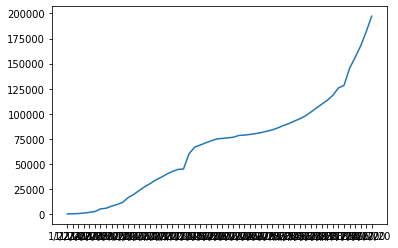

In [17]:
plt.plot(df)

In [18]:
df.tail()

,Infected
3/13/20,145193
3/14/20,156097
3/15/20,167449
3/16/20,181531
3/17/20,197146


In [19]:
forecast

198712

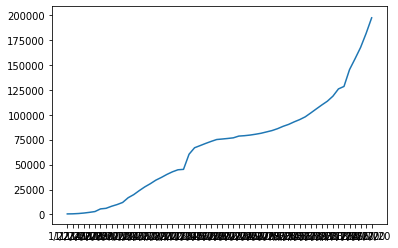

In [20]:
plt.plot(df)
plt.plot(forecast)

In [21]:
type(df.index)

pandas.core.indexes.base.Index

In [22]:
df.tail()

,Infected
3/13/20,145193
3/14/20,156097
3/15/20,167449
3/16/20,181531
3/17/20,197146


In [23]:
df.tail(10)

,Infected
3/8/20,109795
3/9/20,113561
3/10/20,118592
3/11/20,125865
3/12/20,128343
3/13/20,145193
3/14/20,156097
3/15/20,167449
3/16/20,181531
3/17/20,197146


In [24]:
d

NameError: name 'd' is not defined